In [1]:
import os
import numpy as np
import music21 as m21
import pandas as pd
import json
import matplotlib.pyplot as plt
from scipy import stats
from scipy import spatial
import time

np.random.seed(777)
us = m21.environment.UserSettings()

# us['musescoreDirectPNGPath']="/home/sirivasv/Downloads/MuseScore-3.4.2-x86_64.AppImage"
us['musescoreDirectPNGPath']='/home/sirivasv/.local/bin/MuseScore-3.5.2.312125617-x86_64.AppImage'

# Define dataset paths
# MXML_PATH="/media/sirivasv/JASON/Saul/MCC/DATASETS/DATASUBSET/MTC-ANN-2.0.1/mid"
MXML_PATH="/media/sirivasv/DATAL/MCC/DATASUBSET/MTC-ANN-2.0.1/mid"

# METADATA_PATH="/media/sirivasv/JASON/Saul/MCC/DATASETS/DATASUBSET/MTC-ANN-2.0.1/metadata"
METADATA_PATH="/media/sirivasv/DATAL/MCC/DATASUBSET/MTC-ANN-2.0.1/metadata" 

## Data

In [2]:
# Read table of tune family
tune_family_filename = "MTC-ANN-tune-family-labels.csv"
tune_family_df = pd.read_csv(os.path.join(METADATA_PATH, tune_family_filename), header=None)
tune_family_df.head()

,0,1
0,NLB072587_01,Daar_ging_een_heer_1
1,NLB072587_02,Daar_ging_een_heer_1
2,NLB072774_02,Daar_ging_een_heer_1
3,NLB073046_01,Daar_ging_een_heer_1
4,NLB073588_01,Daar_ging_een_heer_1


In [3]:
# Traverse musicxml files and tune family
song_id_x_family = {}
family_x_songs = {}
for root, directories, files in os.walk(MXML_PATH):
    for file in files:
        song_id = file.split(".")[0]
        if (song_id not in song_id_x_family):
            family_name = tune_family_df[tune_family_df[0] == song_id].iloc[0][1]
            song_id_x_family[song_id] = (file, family_name)
            if (family_name not in family_x_songs):
                family_x_songs[family_name] = []
            family_x_songs[family_name].append(song_id)

In [4]:
# Remove the incomplete anotated tunes from the dataframe
reduced_tune_family_df = tune_family_df[tune_family_df[0].isin(list(song_id_x_family.keys()))]
reduced_tune_family_df.head()

,0,1
0,NLB072587_01,Daar_ging_een_heer_1
1,NLB072587_02,Daar_ging_een_heer_1
2,NLB072774_02,Daar_ging_een_heer_1
3,NLB073046_01,Daar_ging_een_heer_1
4,NLB073588_01,Daar_ging_een_heer_1


## Functions

In [5]:
def getSongKey(song):
    key = song.analyze("key")
    return key

In [6]:
def getSongKeyFromMelody_W_Times(melody_w_times_in_k):
    sc_test = m21.stream.Score()
    p0_test = m21.stream.Part()
    p0_test.id = 'part0'
    for pitch_i in melody_w_times_in_k:
        n_i = m21.note.Note(pitch_i[4])
        p0_test.append(n_i)
    sc_test.insert(0, p0_test)
    return getSongKey(sc_test)

In [7]:
# Function to retrieve a list of midi pitch events and its timestamp
def getMelodyDeltaTimes(eventsintrack):
    
    # Initialize array
    DeltaTimes = []
    
    # Initialize cumulative sum
    cum_sum = 0
    
    # Initialize variable to track the time delta
    prev_deltatime = 0
    
    # Traverse the events
    for ev in eventsintrack:
        
        # If a note starts
        if (ev.isNoteOn()):
            
            # Get the pitch name and save it with the cumulative sum, midi pitch and name
            pitch_in_time = m21.pitch.Pitch(ev.pitch)
            DeltaTimes.append((cum_sum, prev_deltatime, pitch_in_time.midi, pitch_in_time.spanish, pitch_in_time))
            
            # Restart the delta time
            prev_deltatime = 0
        
        # Else if there is a delta time
        elif(str(ev.type) == "DeltaTime"):
            
            # We sum the time
            cum_sum += ev.time
            
            # We sum it to the current delta time
            prev_deltatime += ev.time
    
    # Return the array
    return DeltaTimes

In [8]:
# Read Files 
song_m21_streams = {}

# We traverse the reduced table
for query_row in reduced_tune_family_df.iterrows():
    tune_family_query = query_row[1][1]
    song_id_A = query_row[1][0]
    
    song_stream_A = m21.converter.parseFile(os.path.join(MXML_PATH, song_id_x_family[song_id_A][0]))
    midi_tracks_A = m21.midi.translate.streamToMidiFile(song_stream_A)
    melody_w_times_A = getMelodyDeltaTimes(midi_tracks_A.tracks[0].events)
    
    song_m21_streams[song_id_A] = {
        "song_stream": song_stream_A,
        "midi_tracks": midi_tracks_A,
        "melody_w_times": melody_w_times_A
    }

## Noises

### Type 1. Random Pitch

In [9]:
def get_random_pitch():
    
    new_pitch_class = np.random.randint(0, 12)
    new_pitch_octave = np.random.randint(1, 9)
    
    return m21.pitch.Pitch(octave=new_pitch_octave, pitchClass=new_pitch_class)

In [10]:
# Define apply Transformation type 1: Ruido en notas
def apply_note_noise(melody_w_times_in, percentage=50):
    
    # Track modified notes 
    modified_notes = {}
    
    # Store the length of the melody
    len_melody = len(melody_w_times_in)
    
    # According to the desired percentage of noise we get the number of notes to be modified
    many_notes = int((len_melody * percentage)//100)
    
    for noise_i in range(many_notes):
        
        # Select a random position that we haven't seen yet
        note_to_change = np.random.randint(0, len_melody)
        while (note_to_change in modified_notes):
            note_to_change = np.random.randint(0, len_melody)
        modified_notes[note_to_change] = 1
        
        # Creating a new pitch note
        previous_pitch = melody_w_times_in[note_to_change][3]
        p_new = get_random_pitch()
        while (p_new.spanish == previous_pitch):
            p_new = get_random_pitch()
        
        
        # Replace the data 
        melody_w_times_in[note_to_change] = (
            melody_w_times_in[note_to_change][0],
            melody_w_times_in[note_to_change][1],
            p_new.midi,
            p_new.spanish,
            p_new)
    
    # Return the modified melody
    return melody_w_times_in

### Type 2. Random DeltaTime

In [11]:
def recalculate_timestamps(melody_w_times_in):
    
    # Store the length of the melody
    len_melody = len(melody_w_times_in)
    
    # Define current start time
    current_start_time = 0
    
    # Traverse the melody
    for note_i in range(len_melody):
        current_start_time += melody_w_times_in[note_i][1]
        melody_w_times_in[note_i] = (
            current_start_time,
            melody_w_times_in[note_i][1],
            melody_w_times_in[note_i][2],
            melody_w_times_in[note_i][3],
            melody_w_times_in[note_i][4])
    
    # Return the recalculated melody
    return melody_w_times_in

In [12]:
def get_random_deltatime():
    return np.random.randint(0, 4097)

In [13]:
# Define apply Transformation type 2: Ruido en tiempos
def apply_deltatime_noise(melody_w_times_in, percentage=50):
    
    # Track modified notes 
    modified_notes = {}
    
    # Store the length of the melody
    len_melody = len(melody_w_times_in)
    
    # According to the desired percentage of noise we get the number of notes to be modified
    many_notes = int((len_melody * percentage)//100)
    
    for noise_i in range(many_notes):
        
        # Select a random position that we haven't seen yet
        note_to_change = np.random.randint(0, len_melody)
        while (note_to_change in modified_notes):
            note_to_change = np.random.randint(0, len_melody)
        modified_notes[note_to_change] = 1
        
        # Creating a new deltatime
        previous_deltatime = melody_w_times_in[note_to_change][1]
        deltatime_new = get_random_deltatime()
        while (deltatime_new == previous_deltatime):
            deltatime_new = get_random_deltatime()
        
        # ratio_of_change = np.abs((deltatime_new - previous_deltatime))
        # if previous_deltatime != 0:
        #     ratio_of_change /= previous_deltatime
        # else:
        #     ratio_of_change = -1
        # print("AAA", ratio_of_change)
        
        # Replace the data 
        melody_w_times_in[note_to_change] = (
            melody_w_times_in[note_to_change][0],
            deltatime_new,
            melody_w_times_in[note_to_change][2],
            melody_w_times_in[note_to_change][3],
            melody_w_times_in[note_to_change][4])
        
        # Recalculate timestamps due to the modification in deltatimes
        melody_w_times_in = recalculate_timestamps(melody_w_times_in)
    
    # Return the modified melody
    return melody_w_times_in

### Type 3. Noise in Pitch and Deltatime

In [14]:
# Define apply Transformation type 3: Ruido en tiempos y notas (reemplazo)
def apply_deltatime_and_note_noise(melody_w_times_in, percentage=50):
    
    # Track modified notes 
    modified_notes = {}
    
    # Store the length of the melody
    len_melody = len(melody_w_times_in)
    
    # According to the desired percentage of noise we get the number of notes to be modified
    many_notes = int((len_melody * percentage)//100)
    
    for noise_i in range(many_notes):
        
        # Select a random position that we haven't seen yet
        note_to_change = np.random.randint(0, len_melody)
        while (note_to_change in modified_notes):
            note_to_change = np.random.randint(0, len_melody)
        modified_notes[note_to_change] = 1
        
        # Creating a new deltatime
        previous_deltatime = melody_w_times_in[note_to_change][1]
        deltatime_new = get_random_deltatime()
        while (deltatime_new == previous_deltatime):
            deltatime_new = get_random_deltatime()
        
        # Creating a new pitch note
        previous_pitch = melody_w_times_in[note_to_change][3]
        p_new = get_random_pitch()
        while (p_new.spanish == previous_pitch):
            p_new = get_random_pitch()
            
        # Replace the data 
        melody_w_times_in[note_to_change] = (
            melody_w_times_in[note_to_change][0],
            deltatime_new,
            p_new.midi,
            p_new.spanish,
            p_new)
        
        # Recalculate timestamps due to the modification in deltatimes
        melody_w_times_in = recalculate_timestamps(melody_w_times_in)
    
    # Return the modified melody
    return melody_w_times_in

### Type 4. Removing notes

In [15]:
# Define apply Transformation type 4: Noise by removing events
def apply_removing_noise(melody_w_times_in, percentage=50):
    
    # Store the length of the melody
    len_melody = len(melody_w_times_in)
    
    # According to the desired percentage of noise we get the number of notes to be modified
    many_notes = int((len_melody * percentage)//100)
    
    for noise_i in range(many_notes):
        
        # Select a random position to remove
        note_to_remove = np.random.randint(0, len(melody_w_times_in))
        
        # Remove element
        melody_w_times_in.pop(note_to_remove)
        
        # Recalculate timestamps due to the modification in deltatimes continuity
        melody_w_times_in = recalculate_timestamps(melody_w_times_in)
    
    # Return the modified melody
    return melody_w_times_in

### Type 5. Inserting new notes

In [16]:
# Define apply Transformation type 5: Noise by Inserting events
def apply_inserting_noise(melody_w_times_in, percentage=50):
    
    # Assert only percentages p <= 100 and p > 0
    if percentage >= 100 or percentage < 0:
        percentage = 99
    
    # Store the length of the melody
    len_melody = len(melody_w_times_in)
    
    # According to the desired percentage of noise we get the number of notes to be modified
    new_len = int(len_melody / (1 - (percentage / 100)))
    many_notes = new_len - len_melody
    
    for noise_i in range(many_notes):
        
        # Create new Event
        # Creating a new deltatime
        deltatime_new = get_random_deltatime()
        
        # Creating a new pitch note
        p_new = get_random_pitch()
            
        # Replace the data 
        new_midi_event = (
            0,
            deltatime_new,
            p_new.midi,
            p_new.spanish,
            p_new)
        
        # Select a random position to insert
        pos_to_insert = np.random.randint(0, len(melody_w_times_in))
        
        # Insert element
        melody_w_times_in.insert(pos_to_insert, new_midi_event)
        
        # Recalculate timestamps due to the modification in deltatimes continuity
        melody_w_times_in = recalculate_timestamps(melody_w_times_in)
    
    # Return the modified melody
    return melody_w_times_in

### Noise Controller

In [17]:
def apply_ith_noise(noise_type, melody_w_times_in, percentage=50):
    
    if (noise_type == 1):
        return apply_note_noise(melody_w_times_in, percentage)
    if (noise_type == 2):
        return apply_deltatime_noise(melody_w_times_in, percentage)
    if (noise_type == 3):
        return apply_deltatime_and_note_noise(melody_w_times_in, percentage)
    if (noise_type == 4):
        return apply_removing_noise(melody_w_times_in, percentage)
    
    return apply_inserting_noise(melody_w_times_in, percentage)

## Experiments

### CITY BLOCK DISTANCE

In [18]:
def get_pitch_vector(melody_w_times):
    return [float(x[2]) for x in melody_w_times]

In [19]:
def get_CityBlockDistance_from_melody_w_times(melody_w_times_query, melody_w_times_test):
    
    if (len(melody_w_times_query) == 0 or len(melody_w_times_test) == 0):
        return 0
    
    pitch_vector_query = get_pitch_vector(melody_w_times_query)
    pitch_vector_test = get_pitch_vector(melody_w_times_test)
    
    max_len = max(len(pitch_vector_query), len(pitch_vector_test))
    # max_len = float(max(len(pitch_vector_query), len(pitch_vector_test)))
    # min_len = min(len(pitch_vector_query), len(pitch_vector_test))
    
    pitch_vector_query.extend([0] * (max_len - len(pitch_vector_query)))
    pitch_vector_test.extend([0] * (max_len - len(pitch_vector_test)))
    
    sim = spatial.distance.cityblock(pitch_vector_query, pitch_vector_test)
    
    return sim / len(pitch_vector_query)
    # return sim / max_len

In [20]:
def apply_threshold(val_x):
    val_x *= 100
    val_x = int(val_x)
    val_x = round(val_x / 10)
    return val_x / 10.0

In [21]:
def get_mean_distance_for_song(song_id_query, with_threshold=False):
    
    # We initialize the mean difference across noises
    diff_x_noises = []
    
    # Metric Values
    metric_values = []
    
    # Difference per percentage
    differences_per_percentage = []
    
    # We traverse the noises
    for noise_type_i in noise_types:
        # if (noise_type_i == 2):
            # continue
        
        # We initialize the mean distance in the current noise
        sorted_distance_mean_current_noise = 0
        
        # We save the similarities differences with the percentage
        similarity_differences_for_mean = []
        
        # We save metric values per noise type
        metric_values_per_noise = []
        
        # We save the values to sort accordingly their position
        metric_values_to_sort_percentage = []
        
        # We traverse the percentages
        max_value_in_percentages = -1
        for noise_percentage_i in noise_percentages:
            
            melody_w_times_query = getMelodyDeltaTimes(
                song_m21_streams[song_id_query]["midi_tracks"].tracks[0].events)
            melody_w_times_test = getMelodyDeltaTimes(
                song_m21_streams[song_id_query]["midi_tracks"].tracks[0].events)

            melody_w_times_test = apply_ith_noise(noise_type_i, melody_w_times_test, noise_percentage_i)
             
            current_similarity = get_CityBlockDistance_from_melody_w_times(
                    melody_w_times_query,
                    melody_w_times_test)
                      
            if (with_threshold):
                current_similarity = apply_threshold(current_similarity)
            
            if (current_similarity > max_value_in_percentages):
                max_value_in_percentages = current_similarity
            
            metric_values_per_noise.append(current_similarity)
            metric_values_to_sort_percentage.append(current_similarity)
            
        # Get Similarities differences
        for nid, noise_percentage_i in enumerate(noise_percentages):
            if (max_value_in_percentages > 0.0):
                metric_values_to_sort_percentage[nid] /= max_value_in_percentages
        for nid, noise_percentage_i in enumerate(noise_percentages):
            noise_percentage_i /= 100.0
            similarity_differences_for_mean.append(np.abs(metric_values_to_sort_percentage[nid] - noise_percentage_i))
        
        # Get the mean of the 
        similarity_difference_mean_current_noise = np.mean(similarity_differences_for_mean)
        
        # Save the differences per percentage
        differences_per_percentage.append(similarity_differences_for_mean)
        
        # Save the metric values per percentage
        metric_values.append(metric_values_per_noise)
        
        # We sum the distance for this noise
        diff_x_noises.append(similarity_difference_mean_current_noise)
    
    # We return the mean distance per noise
    return metric_values, differences_per_percentage, diff_x_noises

In [22]:
melody_w_times_query_gbl = getMelodyDeltaTimes(song_m21_streams['NLB072967_01']["midi_tracks"].tracks[0].events)
melody_w_times_test_gbl = getMelodyDeltaTimes(song_m21_streams['NLB072967_01']["midi_tracks"].tracks[0].events)
melody_w_times_test_gbl = apply_ith_noise(1, melody_w_times_test_gbl, 50)
pitch_vector_query = [float(x[2]) for x in melody_w_times_query_gbl]
pitch_vector_test = [float(x[2]) for x in melody_w_times_test_gbl]
sim = spatial.distance.euclidean(pitch_vector_query, pitch_vector_test)
max_len = float(max(len(pitch_vector_query), len(pitch_vector_test)))
print(sim)

148.56648343418513


## No Threshold

In [23]:
%%time
# Define noise type array
noise_types = [1, 2, 3, 4, 5]
len_noise_types = len(noise_types)

# Define the percentages of noise
noise_percentages = list(map(int, np.linspace(10, 100, 10)))

# TEST
metric_values_no_thd, differences_per_percentage_no_thd, diff_x_noises_no_thd = get_mean_distance_for_song('NLB072967_01', False)

CPU times: user 3.78 s, sys: 0 ns, total: 3.78 s
Wall time: 3.78 s


In [24]:
print(np.mean(diff_x_noises_no_thd))

0.16965518044547542


## Graphs

In [25]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [26]:
def plot_conf_noises(metric_values_, differences_percentages_, diff_x_noises_):
    fig, axs = plt.subplots(7, 1, figsize=(12, 6 * 7))
    # print(differences_percentages_)
    
    # Graphs per noise type
    for noise_i in range(len_noise_types):
        axs_to_plot = axs[noise_i]
        rects = axs_to_plot.bar(list(map(str, np.linspace(10, 100, 10))), differences_percentages_[noise_i])
        autolabel(rects, axs_to_plot)
        axs_to_plot.set_title(label="Noise #" + str(noise_i + 1))
    
    # Graph mean per percentage across noises
    grouped_percentage_values = []
    for percentage in map(int, np.linspace(10, 100, 10)):
        grouped_percentage_values.append([])
        
    for noise_i in range(len_noise_types):
        perc_i = 0
        for percentage in map(int, np.linspace(10, 100, 10)):
            grouped_percentage_values[perc_i].append(differences_percentages_[noise_i][perc_i])
            perc_i += 1
    perc_i = 0
    for percentage in map(int, np.linspace(10, 100, 10)):
        grouped_percentage_values[perc_i] = np.mean(grouped_percentage_values[perc_i])
        perc_i += 1
        
    axs_to_plot = axs[5]
    rects = axs_to_plot.bar(list(map(str, np.linspace(10, 100, 10))), grouped_percentage_values, color="orange")
    autolabel(rects, axs_to_plot)
    axs_to_plot.set_title(label="Mean Differences across all Noises")
    
    # Graph with mean for each noise accross percentages
    axs_to_plot = axs[6]
    rects = axs_to_plot.bar(list(range(1,6)), list(map(np.mean, differences_percentages_)), color="red")
    autolabel(rects, axs_to_plot)
    axs_to_plot.set_title(label="Mean Noise Difference")
        

In [27]:
def get_mean_diff_vectors(differences_percentages_):
    # Get Mean per percentage across noises
    grouped_percentage_values = []
    for percentage in map(int, np.linspace(10, 100, 10)):
        grouped_percentage_values.append([])
        
    for noise_i in range(len_noise_types):
        perc_i = 0
        for percentage in map(int, np.linspace(10, 100, 10)):
            grouped_percentage_values[perc_i].append(differences_percentages_[noise_i][perc_i])
            perc_i += 1
    perc_i = 0
    for percentage in map(int, np.linspace(10, 100, 10)):
        grouped_percentage_values[perc_i] = np.mean(grouped_percentage_values[perc_i])
        perc_i += 1
        
    return grouped_percentage_values, list(map(np.mean, differences_percentages_))

In [28]:
def plot_conf_best_noises(raw_calculations):
    fig, axs = plt.subplots(2, 1, figsize=(12, 6 * 2))
    differences_percentages_ = raw_calculations[1]
    # Graph mean per percentage across noises
    grouped_percentage_values = []
    for percentage in map(int, np.linspace(10, 100, 10)):
        grouped_percentage_values.append([])
        
    for noise_i in range(len_noise_types):
        perc_i = 0
        for percentage in map(int, np.linspace(10, 100, 10)):
            grouped_percentage_values[perc_i].append(differences_percentages_[noise_i][perc_i])
            perc_i += 1
    perc_i = 0
    for percentage in map(int, np.linspace(10, 100, 10)):
        grouped_percentage_values[perc_i] = np.mean(grouped_percentage_values[perc_i])
        perc_i += 1
        
    axs_to_plot = axs[0]
    rects = axs_to_plot.bar(list(map(str, np.linspace(10, 100, 10))), grouped_percentage_values, color="orange")
    autolabel(rects, axs_to_plot)
    axs_to_plot.set_title(label="Mean Differences across all Noises")
    
    # Graph with mean for each noisea accross percentages
    axs_to_plot = axs[1]
    rects = axs_to_plot.bar(list(range(1,6)), list(map(np.mean, differences_percentages_)), color="red")
    autolabel(rects, axs_to_plot)
    axs_to_plot.set_title(label="Mean Noise Difference")

## Experiment results

In [29]:
%%time

mad_and_std_per_noise_and_percentage = {}

metric_values_no_thd, differences_per_percentage_no_thd, diff_x_noises_no_thd = get_mean_distance_for_song('NLB072967_01', False)

per_percentage_mean_diffs, per_noise_mean_diffs = get_mean_diff_vectors(differences_per_percentage_no_thd)
mad_and_std_per_noise_and_percentage["noise"] = (
    stats.median_abs_deviation(per_noise_mean_diffs),
    np.std(per_noise_mean_diffs, dtype=np.float64),
    np.mean(per_noise_mean_diffs)
)
print(mad_and_std_per_noise_and_percentage["noise"])
mad_and_std_per_noise_and_percentage["percentage"] = (
    stats.median_abs_deviation(per_percentage_mean_diffs),
    np.std(per_percentage_mean_diffs, dtype=np.float64),
    np.mean(per_percentage_mean_diffs)
)
print(mad_and_std_per_noise_and_percentage["percentage"])
mad_and_std_per_noise_and_percentage["raw"] = (
    metric_values_no_thd,
    differences_per_percentage_no_thd,
    diff_x_noises_no_thd
)

(0.008562437351734564, 0.19016406104406203, 0.17744596397526124)
(0.06456899933934229, 0.09902863650132368, 0.17744596397526122)
CPU times: user 3.49 s, sys: 0 ns, total: 3.49 s
Wall time: 3.49 s


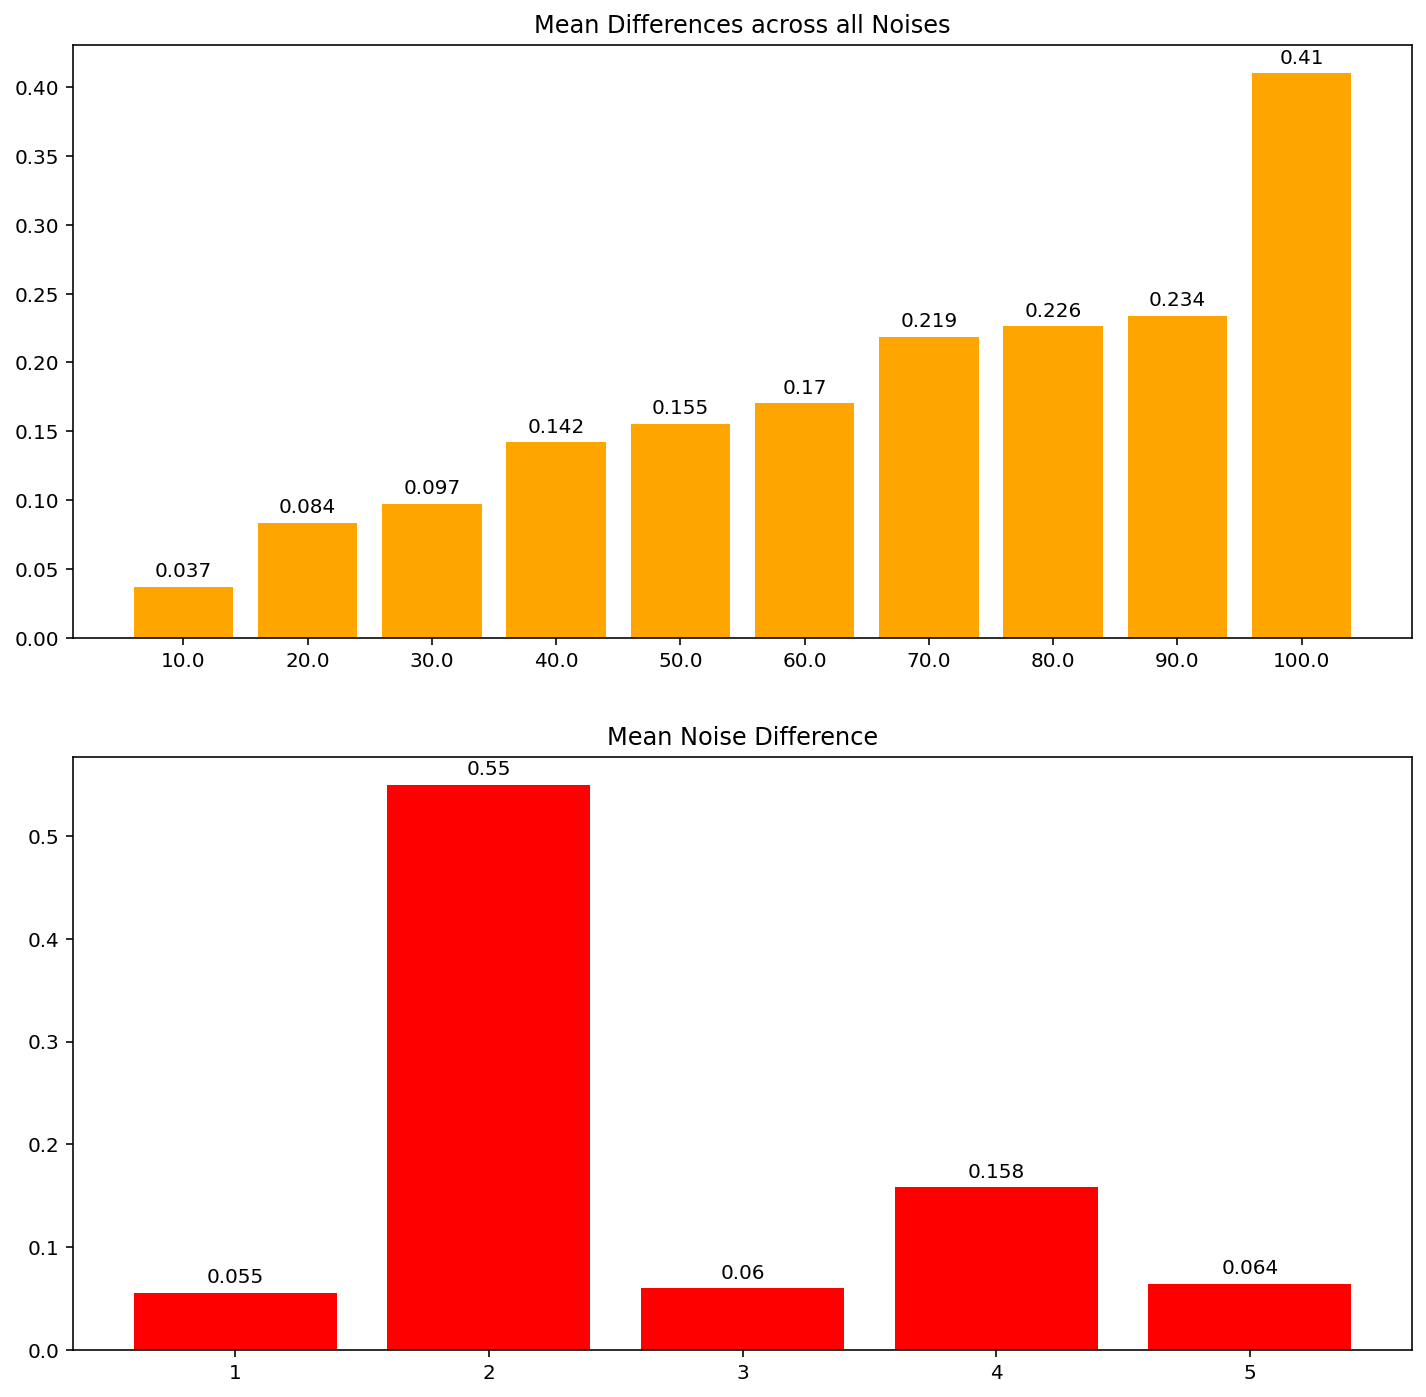

In [30]:
plot_conf_best_noises(mad_and_std_per_noise_and_percentage["raw"])